In [3]:
!pip install -U portalocker>=2.0.0

zsh:1: 2.0.0 not found


## PyTorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [73]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [74]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

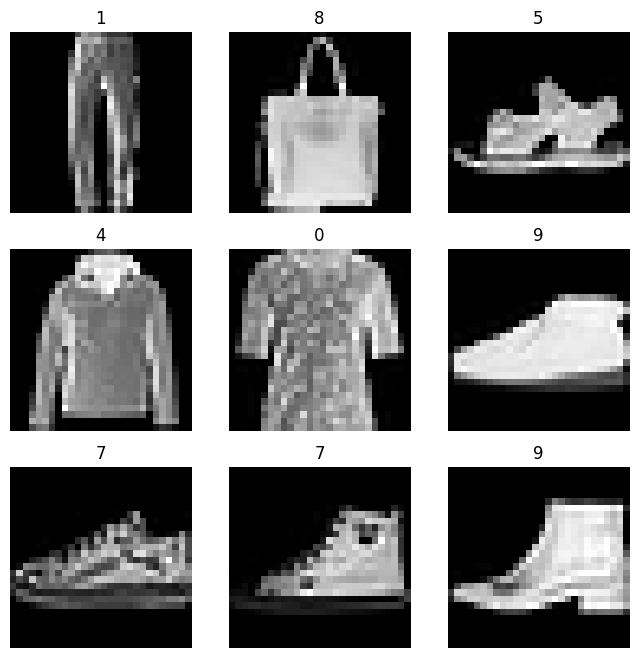

In [75]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [82]:
#Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256) ## First fully connected linear layer, 28*28 input features and 32 outputs
        self.fc2 = nn.Linear(256 , 128) ## Second fully connected linear layer, 32 inputs and 16 outputs
        self.fc2_1 = nn.Linear(128, 64)
        self.fc2_2 = nn.Linear(64, 32)
        self.fc2_3 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10) ## 10 output features because MNIST has 10 target classes

    def forward(self, x): #this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28) #the array is sent in as a vector
        x = torch.sigmoid(self.fc1(x)) ## Applying sigmoid activation for the first layer
        x = torch.tanh(self.fc2(x)) ## Applying tanh activation for the second layer
        x = torch.tanh(self.fc2_1(x))
        x = torch.relu(self.fc2_2(x))
        x = torch.relu(self.fc2_3(x))
        x = self.fc3(x) ## no modifications to the activation of the output layer
        return x

# Initializing the neural network
model = MLP()

In [83]:

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the neural network
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 1.7654364681243897
Epoch 1, Batch 200, Loss: 1.0151229214668274
Epoch 1, Batch 300, Loss: 0.7308707988262176
Epoch 1, Batch 400, Loss: 0.6677068600058556
Epoch 1, Batch 500, Loss: 0.6013151124119759
Epoch 1, Batch 600, Loss: 0.5609830525517464
Epoch 1, Batch 700, Loss: 0.5232785421609879
Epoch 1, Batch 800, Loss: 0.5137086352705955
Epoch 1, Batch 900, Loss: 0.5093313053250312
Epoch 2, Batch 100, Loss: 0.4855357974767685
Epoch 2, Batch 200, Loss: 0.44611777141690256
Epoch 2, Batch 300, Loss: 0.4520362187922001
Epoch 2, Batch 400, Loss: 0.45497595429420473
Epoch 2, Batch 500, Loss: 0.4334766064584255
Epoch 2, Batch 600, Loss: 0.437695799022913
Epoch 2, Batch 700, Loss: 0.3931149333715439
Epoch 2, Batch 800, Loss: 0.41693642020225524
Epoch 2, Batch 900, Loss: 0.404570140838623
Epoch 3, Batch 100, Loss: 0.39058936059474947
Epoch 3, Batch 200, Loss: 0.3817224344611168
Epoch 3, Batch 300, Loss: 0.3767688772082329
Epoch 3, Batch 400, Loss: 0.3847011071443558
Epoch 3,

In [84]:
# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total * 100}%')

Accuracy on test set: 88.24%


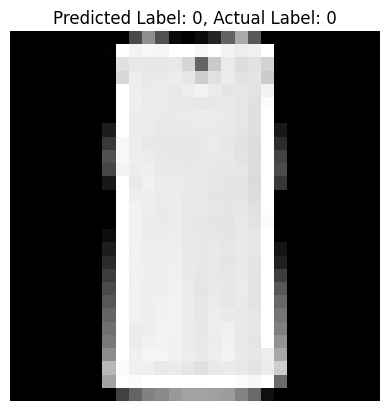

In [24]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation fucntion:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## CNN Implimentation with Keras

In [ ]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np

In [ ]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [ ]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
def create_model(num_layers=2, units_per_layer=128, activation='relu'):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation=activation))

    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
num_layers = 6
units_per_layer = 256
activation = 'relu'
learning_rate = 0.01
epochs = 75
batch_size = 48

# Create the model
model = create_model(num_layers=num_layers, units_per_layer=units_per_layer, activation=activation)

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

In [ ]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

In [ ]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='tanh'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=25)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

## AUTOMATED TUNING (EXETENDED)

In [ ]:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams